### Environment Preparation

In [ ]:
# !pip install swifter pandas numpy
# !pip install -q -U keras-tuner
# !pip uninstall -y tensorflow-gpu keras keras-transformer keras_bert
# !pip install tensorflow-gpu==1.14.0 keras==2.2.4 keras-transformer==0.33.0 keras_bert==0.78.0 
# !pip install tensorflow-gpu keras keras-transformer keras_bert tensorflow-ranking
# !pip install pydot pydotplus
# !pip install h5py==2.10.0 --force-reinstall
# !apt-get install graphviz -y

### Download required embedding

In [ ]:
# !wget https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip data/
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip data/
# !wget https://nlp.stanford.edu/data/glove.840B.300d.zip data/

In [ ]:
# !unzip data/uncased_L-12_H-768_A-12.zip 
# !unzip data/crawl-300d-2M.vec.zip
# !unzip data/glove.840B.300d.zip 

### Run Preprocessing File

In [ ]:
# !python preprocess.py

### Imports


In [1]:
import os
import gc
import json
import pandas as pd
import numpy as np
from random import choice, seed
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, CuDNNLSTM as LSTM, Dropout, BatchNormalization
from keras.layers import Dense, Concatenate, Embedding, Bidirectional, Lambda, Conv1D
from keras.layers import Add, TimeDistributed, GlobalMaxPooling1D
from tensorflow.compat.v1.keras.optimizers import Adam, Nadam
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import keras_tuner as kt
import keras
from keras_bert.loader import load_trained_model_from_checkpoint
from keras_bert import AdamWarmup, calc_train_steps
from keras.models import Model
from keras.models import load_model
from keras_bert import get_custom_objects
from keras_bert import Tokenizer
from collections import defaultdict
from eval import read_submission, get_ndcg
from tqdm import tqdm, trange
import pickle
import dask.dataframe as dd
import joblib


BERT_PRETRAINED_DIR = "/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12"
VAL_ANS_PATH = '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/valid_answer.json'
LABEL_PATH = '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/multimodal_labels.txt'

MAX_EPOCH = 20
MAX_LEN = 10
B_SIZE = 256
FOLD_IDS = [-1]
FOLD_NUM = 20
THRE = 0.5
SHUFFLE = True
MAX_BOX = 5
MAX_CHAR = 5
PREFIX = "[image-bert-concat-query]-wwm_uncased_L12-768_v3_1M_example"
SEED = 2021
ACCUM_STEP = int(128 // B_SIZE)
SAVE_EPOCHS=[10, 20, 35, 50, 80, 100]
IMAGE_LABEM_CONCAT_TOKEN = "###"
CONCAT_TOKE = "[unused0]"

cfg = {}
cfg["verbose"] = PREFIX
cfg["base_dir"] = BERT_PRETRAINED_DIR
cfg['maxlen'] = MAX_LEN
cfg["max_box"] = MAX_BOX
cfg["max_char"] = MAX_CHAR
cfg["lr"] = 1e-4
cfg['min_lr'] = 6e-8
cfg["opt"] = "nadam"
cfg["loss_w"] =  20.
cfg["trainable"] = True
cfg["bert_trainable"] = True
cfg["mix_mode"] = ""   # add concat average
cfg["unit1_1"] = 128
cfg["accum_step"] = ACCUM_STEP
cfg["cls_num"] = 2
cfg["raw_filename"] = "{}_{}oof{}"

In [2]:
def get_vocab():
    
    if "albert"in cfg["verbose"].lower():
        dict_path = os.path.join(BERT_PRETRAINED_DIR, 'vocab_chinese.txt')
    else:
        dict_path = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
    with open(dict_path, mode="r", encoding="utf8") as f:
        lines = f.readlines()
        lines = [l.strip() for l in lines]

    word_index = {v: k  for k, v in enumerate(lines)}
    return word_index


word_index = get_vocab()
cfg["x_pad"] = word_index["[PAD]"]
tokenizer = Tokenizer(word_index)


def get_label(path):
    with open(path) as f:
        lines = f.readlines()
        label2id = {l.split('\n')[0].split('\t')[1]:int(l.split('\n')[0].split('\t')[0]) for l in lines[1:]}
        id2label = {int(l.split('\n')[0].split('\t')[0]):l.split('\n')[0].split('\t')[1] for l in lines[1:]}
    return label2id, id2label


label2id, id2label = get_label(LABEL_PATH)
label_set = set(label2id.keys())

In [13]:
# with open('../data/train_data.pkl', 'rb') as outp:
#     train_data= joblib.load(outp)
# 100K sample
with open('data/100K_data.pkl', 'rb') as outp:
    train_data = joblib.load(outp)

with open("data/sample_val.pkl", "rb") as f:
    val_data = joblib.load(f)

# with open('data/val_data.pkl', 'rb') as outp:
#     val_data = pickle.load(outp)

In [4]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype=np.float16)


def load_embed(path, dim=300, word_index=None):
    embedding_index = {}
    with open(path, mode="r", encoding="utf8") as f:
        lines = f.readlines()
        for l in lines:
            l = l.strip().split()
            word, arr = l[0], l[1:]
            if len(arr) != dim:
                print("[!] l = {}".format(l))
                continue
            if word_index and word not in word_index:
                continue
            word, arr = get_coefs(word, arr)
            embedding_index[word] = arr
    return embedding_index


def build_matrix(path, word_index=None, max_features=None, dim=300):
    embedding_index = load_embed(path, dim=dim, word_index=word_index)
    max_features = len(word_index) + 1 if max_features is None else max_features 
    embedding_matrix = np.zeros((max_features + 1, dim))
    unknown_words = []
    
    for word, i in word_index.items():
        if i <= max_features:
            try:
                embedding_matrix[i] = embedding_index[word]
            except KeyError:
                unknown_words.append(word)
    return embedding_matrix, unknown_words


def load_word_embed(word_embed_glove="data/glove.840B.300d.txt", 
                    word_embed_crawl="data/crawl-300d-2M.vec",
               save_filename="word_embedding_matrix",
               word_index=None):
    """
    (30524, 300) 7590
    (30524, 300) 7218
    """    
    if os.path.exists(save_filename + ".npy"):
        word_embedding_matrix = np.load(save_filename + ".npy").astype("float32")
    else:
        word_embedding_matrix, _ = build_matrix(word_embed_glove, word_index=word_index, dim=300)
        word_embedding_matrix_v2, _ = build_matrix(word_embed_crawl, word_index=word_index, dim=300)
        word_embedding_matrix = np.concatenate([word_embedding_matrix, word_embedding_matrix_v2], axis=1)
        
        gc.collect()
        np.save(save_filename, word_embedding_matrix)
    return word_embedding_matrix


word_embedding_matrix = load_word_embed(word_index=word_index)

In [5]:
def build_model(cfg, summary=False, word_embedding_matrix=None):
    
    def _get_model(base_dir, cfg_=None):
        config_file = os.path.join(base_dir, 'bert_config.json')
        checkpoint_file = os.path.join(base_dir, 'bert_model.ckpt')
        if not os.path.exists(config_file):
            config_file = os.path.join(base_dir, 'bert_config_large.json')
            checkpoint_file = os.path.join(base_dir, 'roberta_l24_large_model')
        # print(config_file, checkpoint_file)
        model = load_trained_model_from_checkpoint(config_file, 
                                           checkpoint_file, 
                                           training=False, 
                                           trainable=cfg_["bert_trainable"], 
                                           output_layer_num=cfg["cls_num"],
                                           seq_len=None)
        return model
    
    def get_opt(num_example, warmup_proportion=0.1, lr=2e-5, min_lr=None):
        if cfg["opt"].lower() == "nadam":
            opt = Nadam(lr=lr)
        else:
            total_steps, warmup_steps = calc_train_steps(
                num_example=num_example,
                batch_size=B_SIZE,
                epochs=MAX_EPOCH,
                warmup_proportion=warmup_proportion,
            )

            opt = AdamWarmup(total_steps, warmup_steps, lr=lr, min_lr=min_lr)

        return opt

    model1 = _get_model(cfg["base_dir"], cfg)
    model1 = Model(inputs=model1.inputs[: 2], outputs=model1.layers[-7].output)

    if word_embedding_matrix is not None:
        embed_layer = Embedding(input_dim=word_embedding_matrix.shape[0], 
                                output_dim=word_embedding_matrix.shape[1],
                                weights=[word_embedding_matrix],
                                trainable=cfg["trainable"],
                                name="embed_layer"
                         )
        
    inp_token1 = Input(shape=(None, ), dtype=np.int32, name="query_token_input")
    inp_segm1 = Input(shape=(None, ), dtype=np.float32, name="query_segm_input")
      
    
    inp_image = Input(shape=(None, 2048), dtype=np.float32, name="image_input")
    inp_image_mask = Input(shape=(None, ), dtype=np.float32, name="image_mask_input")
    inp_pos = Input(shape=(None, 5), dtype=np.float32, name="image_pos_input")        
    inp_image_char = Input(shape=(None, cfg["max_char"]), dtype=np.int32, name='image_char_input')
    
    
    mask = Lambda(lambda x: K.cast(K.not_equal(x, cfg["x_pad"]), 'float32'), name="token_mask")(inp_token1)
    word_embed = embed_layer(inp_token1)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])
    word_embed = Bidirectional(LSTM(cfg["unit1_1"], return_sequences=True), merge_mode="sum")(word_embed)
    word_embed = BatchNormalization()(word_embed)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])

    sequence_output = model1([inp_token1, inp_segm1])
    sequence_output = Concatenate(axis=-1)([sequence_output, word_embed])
    text_pool = Lambda(lambda x: x[:, 0, :])(sequence_output)

    # Share weights of character-level embedding for premise and hypothesis
    character_embedding_layer = TimeDistributed(Sequential([
        embed_layer,
        # Embedding(input_dim=100, output_dim=char_embedding_size, input_length=chars_per_word),
        Conv1D(filters=128, kernel_size=3, name="char_embed_conv1d"),
        GlobalMaxPooling1D()
    ]), name='CharEmbedding')
    character_embedding_layer.build(input_shape=(None, None, cfg["max_char"]))
    image_char_embed  = character_embedding_layer(inp_image_char)    
    image_embed = Concatenate(axis=-1)([image_char_embed, inp_image])    
    image_embed = Dense(256, activation='relu', name='image_embed')(image_embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    pos_embed = Dense(256, activation='relu', name='pos_embed')(inp_pos)
    pos_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([pos_embed, inp_image_mask])
    embed = Add()([image_embed , pos_embed]) # batch, maxlen(10), 1024+128
    
    image_embed = Bidirectional(LSTM(512, return_sequences=True), merge_mode="sum")(embed)
    image_embed = BatchNormalization()(image_embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    
    image_pool = Lambda(lambda x: x[:, 0, :])(image_embed)
    
    pool = Concatenate(axis=-1)([image_pool, text_pool])
    pool = Dense(1024, activation="relu")(pool)
    pool = Dropout(0.3)(pool)
    pool = Dense(512, activation="relu")(pool)
    pool = Dense(128, activation="relu")(pool)
    
    output = Dense(2, activation='softmax', name='output')(pool)

    opt = get_opt(num_example=cfg["num_example"], lr=cfg['lr'], min_lr=cfg['min_lr'])
    model = Model(inputs=[inp_token1, inp_segm1, 
                          inp_image, inp_image_mask,
                          inp_pos, inp_image_char], outputs=[output])#
    
    model.compile(optimizer=opt, loss={
                'output': 'sparse_categorical_crossentropy'
            }, metrics=['accuracy'])
    if summary:
        model.summary()
    
    return model


In [6]:
def build_baseline_model(cfg, summary=False, word_embedding_matrix=None):
    
    def _get_model(base_dir, cfg_=None):
        config_file = os.path.join(base_dir, 'bert_config.json')
        checkpoint_file = os.path.join(base_dir, 'bert_model.ckpt')
        if not os.path.exists(config_file):
            config_file = os.path.join(base_dir, 'bert_config_large.json')
            checkpoint_file = os.path.join(base_dir, 'roberta_l24_large_model')
        # print(config_file, checkpoint_file)
        model = load_trained_model_from_checkpoint(config_file, 
                                           checkpoint_file, 
                                           training=False, 
                                           trainable=cfg_["bert_trainable"], 
                                           output_layer_num=cfg["cls_num"],
                                           seq_len=None)
        return model
    
    def get_opt(num_example, warmup_proportion=0.1, lr=2e-5, min_lr=None):
        if cfg["opt"].lower() == "nadam":
            opt = Nadam(lr=lr)
        else:
            total_steps, warmup_steps = calc_train_steps(
                num_example=num_example,
                batch_size=B_SIZE,
                epochs=MAX_EPOCH,
                warmup_proportion=warmup_proportion,
            )

            opt = AdamWarmup(total_steps, warmup_steps, lr=lr, min_lr=min_lr)

        return opt

    # model1 = _get_model(cfg["base_dir"], cfg)
    # model1 = Model(inputs=model1.inputs[: 2], outputs=model1.layers[-7].output)

    global word_index
    word_embedding_matrix = load_word_embed(word_index=word_index)
    embed_layer = Embedding(input_dim=word_embedding_matrix.shape[0], 
                            output_dim=word_embedding_matrix.shape[1],
                            weights=[word_embedding_matrix],
                            trainable=cfg["trainable"],
                            name="embed_layer"
                        )
        
    inp_token1 = Input(shape=(None, ), dtype=np.int32, name="query_token_input")
    inp_segm1 = Input(shape=(None, ), dtype=np.float32, name="query_segm_input")
    
#     inp_token2 = Input(shape=(None, ), dtype=np.int32)
#     inp_segm2 = Input(shape=(None, ), dtype=np.float32)    
    
    inp_image = Input(shape=(None, 2048), dtype=np.float32, name="image_input")
    inp_image_mask = Input(shape=(None, ), dtype=np.float32, name="image_mask_input")
    inp_pos = Input(shape=(None, 5), dtype=np.float32, name="image_pos_input")        
    inp_image_char = Input(shape=(None, cfg["max_char"]), dtype=np.int32, name='image_char_input')
    
    
    mask = Lambda(lambda x: K.cast(K.not_equal(x, cfg["x_pad"]), 'float32'), name="token_mask")(inp_token1)
    word_embed = embed_layer(inp_token1)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])
    
    # hp_units_lstm = hp.Int('lstm_units1', min_value=64, max_value=512, step=32)
    word_embed = Bidirectional(LSTM(cfg["unit1_1"], return_sequences=True), merge_mode="sum")(word_embed)
    word_embed = BatchNormalization()(word_embed)
    # word_embed = Dropout(0.3)(word_embed)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])

    # sequence_output = model1([inp_token1, inp_segm1])
    # sequence_output = Concatenate(axis=-1)([sequence_output, word_embed])
    text_pool = Lambda(lambda x: x[:, 0, :])(word_embed)


    # Share weights of character-level embedding for premise and hypothesis
    character_embedding_layer = TimeDistributed(Sequential([
        embed_layer,
        # Embedding(input_dim=100, output_dim=char_embedding_size, input_length=chars_per_word),
        Conv1D(filters=128, kernel_size=3, name="char_embed_conv1d"),
        GlobalMaxPooling1D()
    ]), name='CharEmbedding')
    character_embedding_layer.build(input_shape=(None, None, cfg["max_char"]))
    image_char_embed  = character_embedding_layer(inp_image_char)    
    image_embed = Concatenate(axis=-1)([image_char_embed, inp_image])    
    image_embed = Dense(256, activation='relu', name='image_embed')(image_embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    pos_embed = Dense(256, activation='relu', name='pos_embed')(inp_pos)
    pos_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([pos_embed, inp_image_mask])
    embed = Add()([image_embed , pos_embed]) # batch, maxlen(10), 1024+128
    
    image_embed = Bidirectional(LSTM(512, return_sequences=True), merge_mode="sum")(embed)
    image_embed = BatchNormalization()(image_embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    
    image_pool = Lambda(lambda x: x[:, 0, :])(image_embed)
    
    pool = Concatenate(axis=-1)([image_pool, text_pool])
    pool = Dense(1024, activation="relu")(pool)
    pool = Dropout(0.3)(pool)
    pool = Dense(512, activation="relu")(pool)
    pool = Dense(128, activation="relu")(pool)
    
    output = Dense(2, activation='softmax', name='output')(pool)

    opt = get_opt(num_example=cfg["num_example"], lr=cfg['lr'], min_lr=cfg['min_lr'])
    model = Model(inputs=[inp_token1, inp_segm1, 
                          inp_image, inp_image_mask,
                          inp_pos, inp_image_char], outputs=[output])#
    
    model.compile(optimizer=opt, loss={
                'output': 'sparse_categorical_crossentropy'
            }, metrics=['accuracy'])
    if summary:
        model.summary()
    
    return model


In [7]:
def token2id_X(X, x_dict, maxlen=None):
    x = tokenizer.tokenize(X)
    if maxlen:
        x = x[: 1] + list(x)[1: maxlen - 1] + x[-1: ]     
    seg = [0 for _ in x]
    token = list(x)
    x = [x_dict[e] if e in x_dict else x_dict["[UNK]"] for e in token]
    assert len(x) == len(seg)
    return x, seg


def seq_padding(X, maxlen=None, padding_value=None, debug=False):
    L = [len(x) for x in X]
    if maxlen is None:
        maxlen = max(L)

    pad_X = np.array([
        np.concatenate([x, [padding_value] * (maxlen - len(x))]) if len(x) < maxlen else x[: maxlen] for x in X
    ])
    if debug:
        print("[!] before pading {}\n".format(X))
        print("[!] after pading {}\n".format(pad_X))
    return pad_X
    

def MyChoice(Myset):
    result = []
    for i in Myset:
        temp_set = set()
        temp_set.add(i)
        cho = choice(list(Myset - temp_set))
        result.append(cho)
    return result


class data_generator:
    
    def __init__(self, data, batch_size=B_SIZE, shuffle=SHUFFLE):
        self.data = data
        self.batch_size = batch_size
        self.steps = len(self.data) // self.batch_size
        self.shuffle = shuffle

        if len(self.data) % self.batch_size != 0:
            self.steps += 1

    def __len__(self):
        return self.steps
    

    def __iter__(self):
        """
        inp_token1,
        inp_segm1,
        inp_image,
        inp_image_mask,
        inp_pos, 
        inp_image_char
        """
        

        while True:
            idxs = list(range(len(self.data)))
            if self.shuffle:
                np.random.shuffle(idxs)
            T1, T2, Image1, Pos1, label_word_list, image1_mask, image1_char = [], [], [], [], [], [], []
            S1, S2, Image2, Pos2, image2_mask, image2_char = [], [], [], [], [], [] # 负样本
            Id_set = set()

            for i in idxs:
                d = self.data.iloc[i]
                text = d['words']
                label_words = d['label_words']
                
                t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])
                image = np.array(d['features'], dtype="float32")
                image = image[: cfg["max_box"]]
                img_mask = [1 for _ in image[: cfg["max_box"]]]
                
                pos = np.array(d['pos'], dtype="float32")
                pos = pos[: cfg["max_box"]]
                
                image_char = [token2id_X(ent, x_dict=word_index)[0] for ent in label_words.split(IMAGE_LABEM_CONCAT_TOKEN)]
                image_char = image_char[: cfg["max_box"]]
                # print("image_char", len(image_char))
                image_char = pad_sequences(image_char, 
                                           maxlen=cfg["max_char"], 
                                           dtype='int32',
                                           padding='post',
                                           truncating='post',
                                           value=cfg["x_pad"])
                
                assert image.shape[0] == pos.shape[0]
                assert image.shape[0] == cfg["max_box"] or image.shape[0] == len(label_words.split(IMAGE_LABEM_CONCAT_TOKEN))
                assert image_char.shape == (image.shape[0], cfg["max_char"])

                T1.append(t1)
                T2.append(t2)
                Image1.append(image)
                image1_mask.append(img_mask)  
                Pos1.append(pos)
                image1_char.append(image_char)
                Id_set.add(i)

                if len(T1) == self.batch_size//2 or i == idxs[-1]:
                    ## 加入负样本
                    Id_new = MyChoice(Id_set)
#                     print(Id_set, Id_new)
                    for i, id_ in enumerate(Id_new):
                        d_new = self.data.iloc[id_]
                        text = d_new['words']
                        t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])
                        S1.append(t1)
                        S2.append(t2)
                        
                        image = Image1[i]
                        img_mask = image1_mask[i]
                        pos = Pos1[i]
                        image_char = image1_char[i]
                        
                        Image2.append(image)
                        Pos2.append(pos)
                        image2_mask.append(img_mask)
                        image2_char.append(image_char)
                    
                    Y = [1] * len(T1) + [0] * len(S1)
                   
                    T1 = seq_padding(T1 + S1, padding_value=cfg["x_pad"]) 
                    T2 = seq_padding(T2 + S2, padding_value=cfg["x_pad"])
                    
                    Image1 = seq_padding(Image1 + Image2, 
                                         padding_value=np.zeros(shape=(2048, ))
                                        )
                                                         
                    Pos1 = seq_padding(Pos1 + Pos2,
                                       padding_value=np.zeros(shape=(5, ))
                                      )
                    image1_mask = seq_padding(image1_mask + image2_mask,
                                             padding_value=0)
                    
                    image1_char = seq_padding(image1_char + image2_char,
                                             padding_value=np.zeros(shape=(cfg["max_char"])), debug=False)
                    
                    Y = np.array(Y).reshape((len(T1), -1))
                    
                    idx = np.arange(len(T1))
                    np.random.shuffle(idx)
        
                    T1 = T1[idx]
                    T2 = T2[idx]
                    Image1 = Image1[idx]
                    image1_mask = image1_mask[idx]
                    Pos1 = Pos1[idx]
                    image1_char = image1_char[idx]
                    Y = Y[idx]
                    
                    yield [T1, T2, Image1, image1_mask, Pos1, image1_char], Y
                    T1, T2, Image1, Pos1, label_word_list, image1_mask, image1_char = [], [], [], [], [], [], []
                    S1, S2, Image2, Pos2, image2_mask, image2_char = [], [], [], [], [], [] # 负样本
                    Id_set = set()

                        

In [14]:
train_D = data_generator(train_data)
val_D = data_generator(val_data)
_i  = 0
for d in train_D:
    _i += 1
    if  _i > 10:
        break
    print('x',d[0][0].shape, d[0][1].shape,d[0][2].shape, d[0][3].shape, d[0][4].shape, d[0][5].shape, d[1].shape)

_i  = 0
for d in val_D:
    _i += 1
    if  _i > 10:
        break
    print('x',d[0][0].shape, d[0][1].shape,d[0][2].shape, d[0][3].shape, d[0][4].shape, d[0][5].shape, d[1].shape)

x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 5, 5) (256, 5, 5) (256, 1)
x (256, 10) (256, 10) (256, 5, 2048) (256, 5) (256, 

In [9]:
class Evaluate(Callback):
    def __init__(self, filename=None):
        self.score = []
        self.best = 0.
        self.filename = filename
       
    def on_epoch_begin(self, epoch, logs=None):
        if epoch ==  0:
            print("[!] test load&save model")
            f = self.filename + ".h5"
            custom_objects = get_custom_objects()
            self.model.save(f, include_optimizer=False, overwrite=True)
            if "bert" in cfg["verbose"]:
                model_ = load_model(f, custom_objects=custom_objects)  
            else:
                model_ = load_model(f) 
    
    def on_epoch_end(self, epoch, logs=None):
#         if epoch + 1 < 5:
#             return
        score = self.evaluate(self.model)
        self.score.append((epoch, score))
        logs['nDCG@5'] = score
        tf.summary.scalar('nDCG@5', score, step=epoch)
        
        if epoch + 1 in SAVE_EPOCHS:
            self.model.save(self.filename + "_{}.h5".format(epoch + 1), include_optimizer=False, overwrite=True)             
        if score > self.best:
            self.model.save(self.filename + ".h5", include_optimizer=False)
            
        if score > self.best:
            self.best = score
            print("[!] epoch = {}, new NDCG best score = {}".format(epoch + 1,  score))
        print('[!] epoch = {}, score = {}, NDCG best score: {}\n'.format(epoch + 1, score, self.best))

    def eval_preprocess(self, row):

            d = row
            text = d['query']
            label_words = d['label_words']
            t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])
            
            image = np.array(d['feature_convert'], dtype="float32")
            image = image[: cfg["max_box"]]
            img_mask = [1 for _ in image[: cfg["max_box"]]]                   
            pos = np.array(d['pos'], dtype="float32")
            pos = pos[: cfg["max_box"]]
            
            image_char = [token2id_X(ent, x_dict=word_index)[0] for ent in label_words.split(IMAGE_LABEM_CONCAT_TOKEN)]
            image_char = image_char[: cfg["max_box"]]
            image_char = pad_sequences(image_char, 
                                       maxlen=cfg["max_char"], 
                                       dtype='int32',
                                       padding='post',
                                       truncating='post',
                                       value=cfg["x_pad"])
            output = self.model.predict([np.asarray([t1]), np.asarray([t2]), np.asarray([image]), np.asarray([img_mask]), np.asarray([pos]), np.asarray([image_char])])
            return output


    def evaluate(self, model):
        self.model = model
        result = defaultdict(list)
        val_results = val_data.apply(self.eval_preprocess, axis=1)
        qid = val_data["query_id"].values
        pid = val_data["product_id"].values


        for i in trange(len(val_data)): 
            result[qid[i]].append((pid[i], val_results[i][0][1]))
            
        query_id,product1,product2,product3,product4,product5 = [],[],[],[],[],[]
        for key in result.keys():
            rlist = result[key]
            rlist.sort(key=lambda x: x[1], reverse=True)
            query_id.append(key)
            product1.append(rlist[0][0])
            product2.append(rlist[1][0])
            product3.append(rlist[2][0])
            product4.append(rlist[3][0])
            product5.append(rlist[4][0])
        sub = pd.DataFrame({'query-id':query_id,
                            'product1':product1,
                            'product2':product2,
                            'product3':product3,
                            'product4':product4,
                            'product5':product5,

        })
        sub.to_csv('result/val_submission.csv',index=0)
        
        reference = json.load(open(VAL_ANS_PATH))
        
        # read predictions
        k = 5
        predictions = read_submission('result/val_submission.csv', reference, k)

        # compute score for each query
        score_sum = 0.
        for qid in reference.keys():
            ground_truth_ids = set([str(pid) for pid in reference[qid]])
            ref_vec = [1.0] * len(ground_truth_ids)
            pred_vec = [1.0 if pid in ground_truth_ids else 0.0 for pid in predictions[qid]]
            score_sum += get_ndcg(pred_vec, ref_vec, k)
        # the higher score, the better
        score = score_sum / len(reference)
        
        return score

## Train Baseline



[!] fold_id = -1 starting
10000
{'verbose': '[image-bert-concat-query]-wwm_uncased_L12-768_v3_1M_example', 'base_dir': '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12', 'maxlen': 10, 'max_box': 5, 'max_char': 5, 'lr': 0.0001, 'min_lr': 6e-08, 'opt': 'nadam', 'loss_w': 20.0, 'trainable': True, 'bert_trainable': True, 'mix_mode': '', 'unit1_1': 128, 'accum_step': 0, 'cls_num': 2, 'raw_filename': '{}_{}oof{}', 'x_pad': 0, 'filename': 'models/100K_baseline', 'num_example': 10000}


2022-01-12 07:11:40.779089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 07:11:42.146885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7954 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:86:00.0, compute capability: 3.7
2022-01-12 07:11:42.148299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7199 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:87:00.0, compute capability: 3.7
/root/.pyenv/versions/3.7.0/envs/team2_ai_light/lib/python3.7/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `lea

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_char_input (InputLayer)  [(None, None, 5)]    0           []                               
                                                                                                  
 CharEmbedding (TimeDistributed  (None, None, 128)   18544928    ['image_char_input[0][0]']       
 )                                                                                                
                                                                                                  
 image_input (InputLayer)       [(None, None, 2048)  0           []                               
                                ]                                                                 
                                                                                              

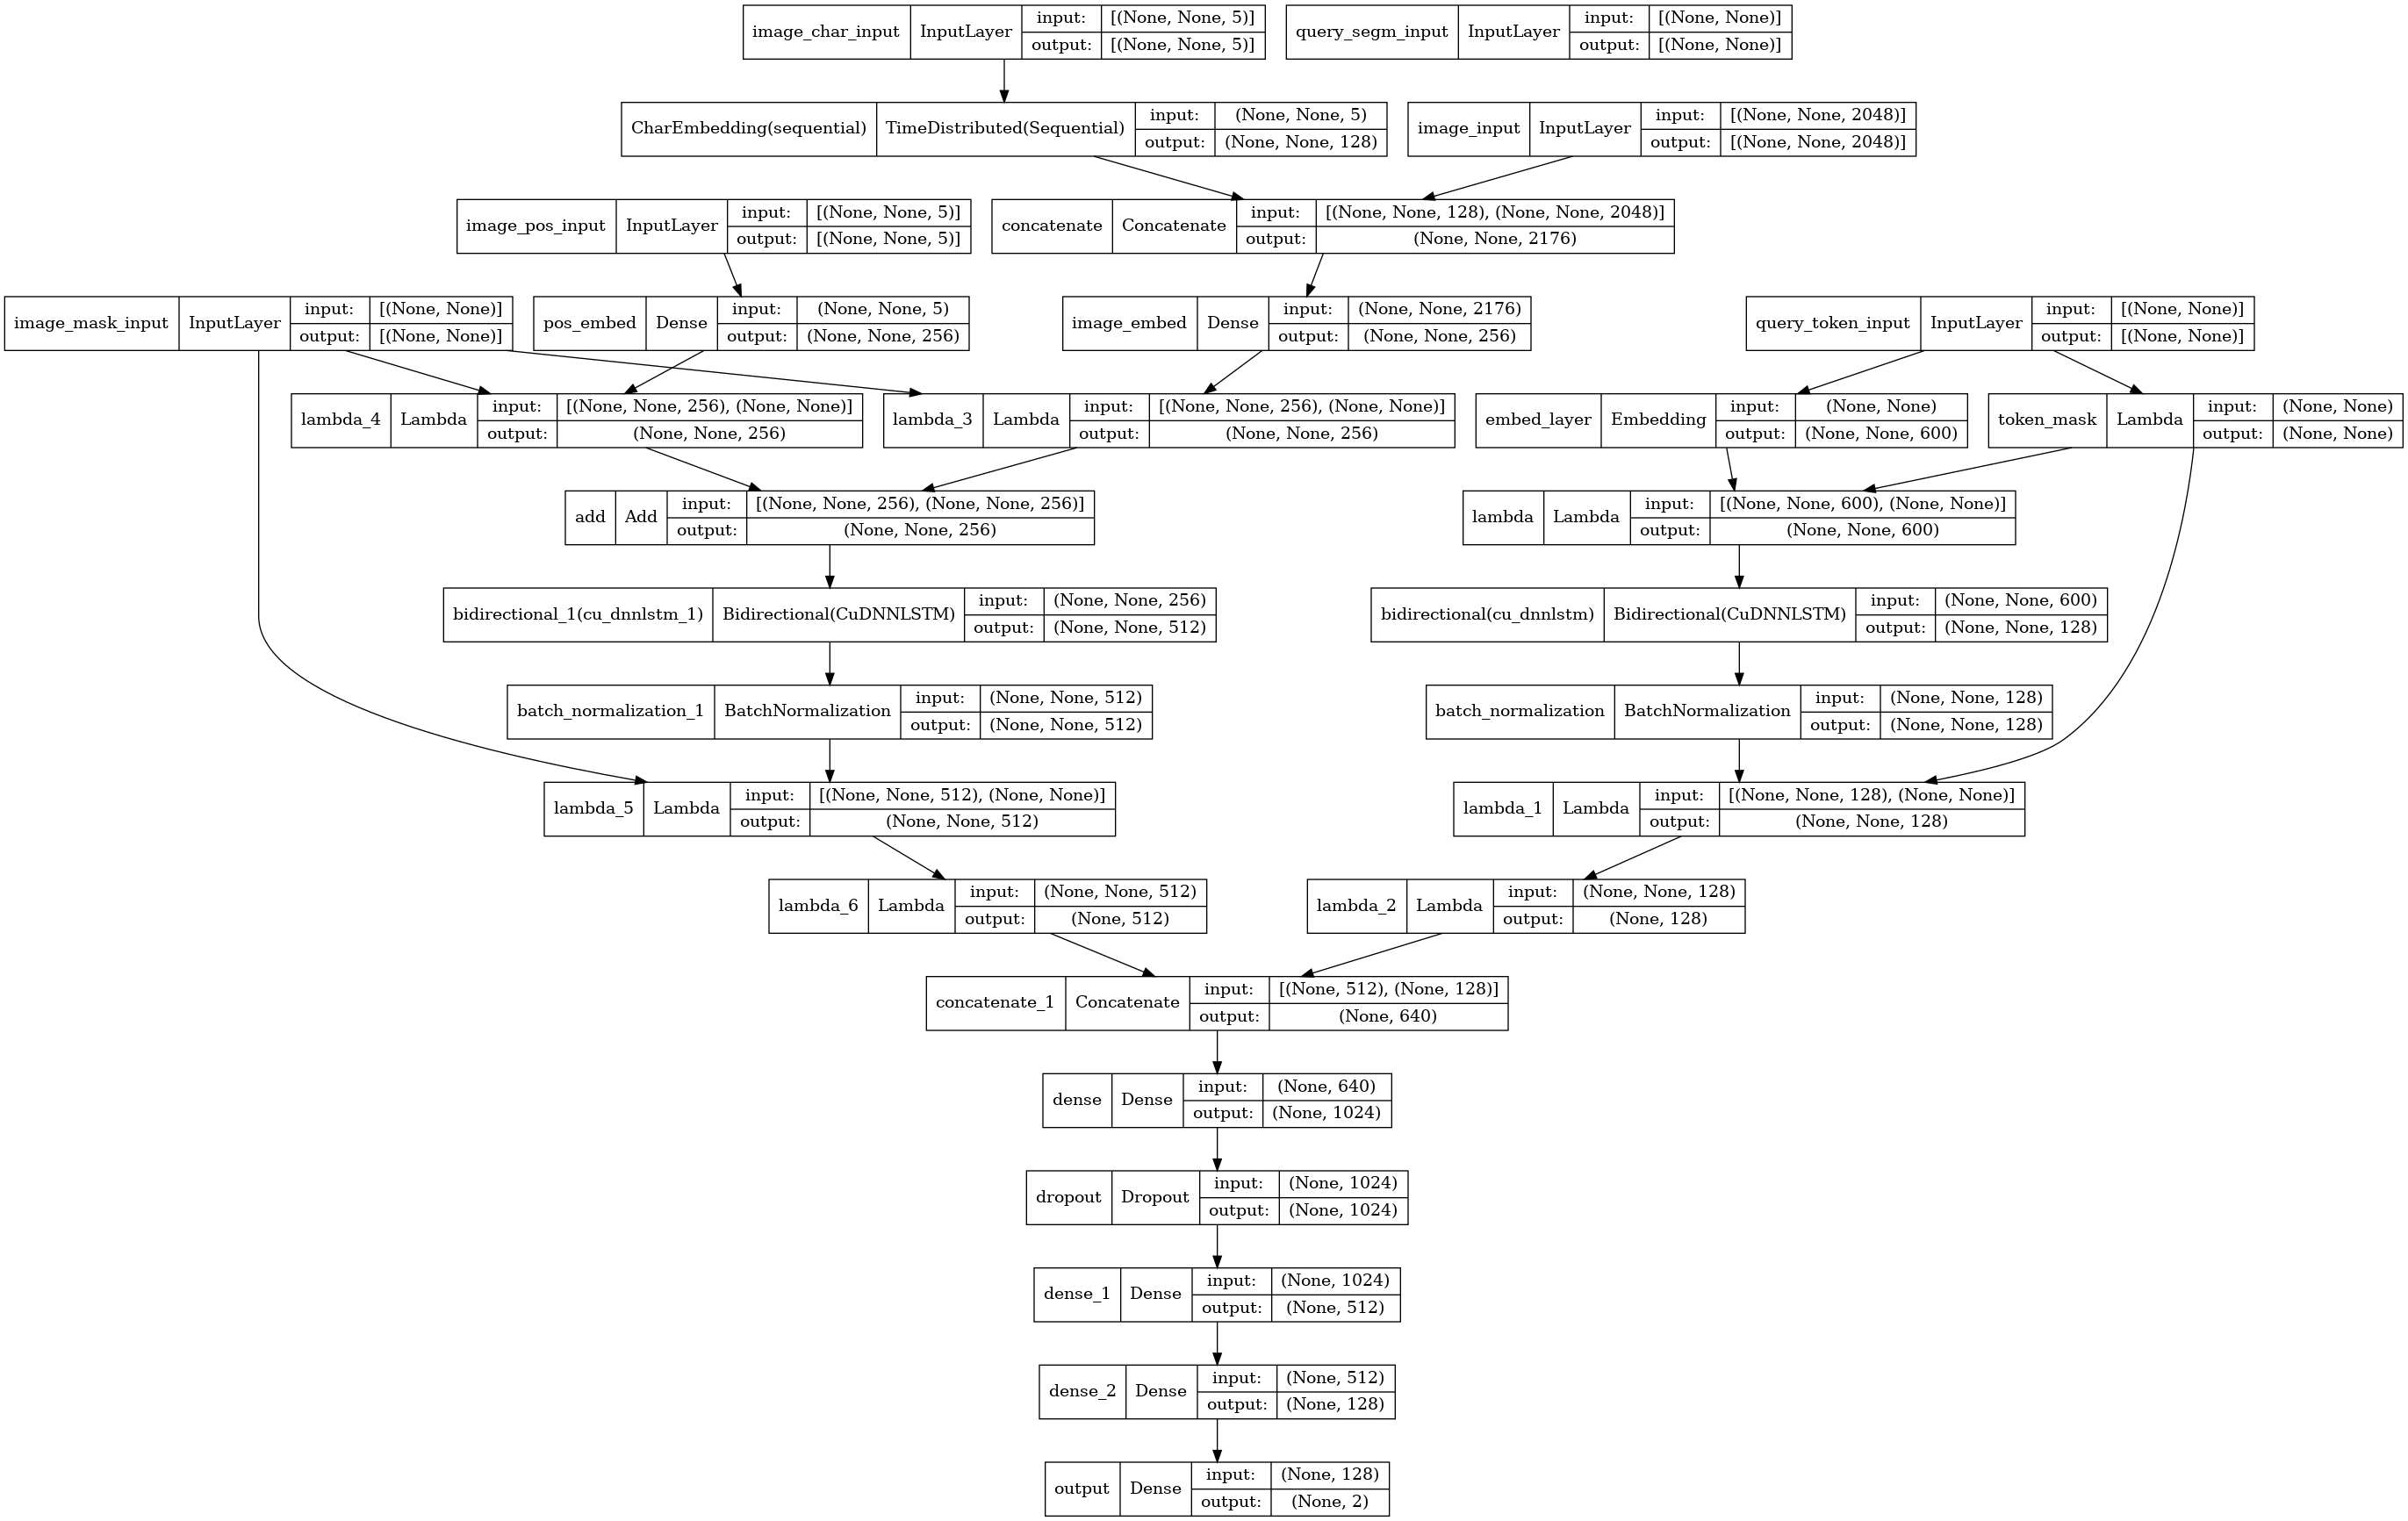

In [10]:

gc.collect()
fold_id = -1
print("\n\n[!] fold_id = {} starting".format(fold_id))
# cfg["filename"] = cfg["raw_filename"].format(cfg["verbose"], FOLD_NUM, fold_id)

cfg["filename"] = 'models/100K_baseline'

cfg["num_example"] = len(train_data)
print(len(train_data))

tf.compat.v1.keras.backend.clear_session()
gc.collect()
seed(SEED - fold_id)
np.random.seed(SEED - fold_id)
tf.compat.v1.random.set_random_seed(SEED - fold_id)
train_D = data_generator(train_data)
print(cfg)
model = build_baseline_model(cfg, summary=True, 
                    word_embedding_matrix=word_embedding_matrix,
                    )
tf.keras.utils.plot_model(model, to_file="models/model_baseline.png", show_shapes=True)


### Model Fitting

In [15]:
evaluator = Evaluate(filename=cfg["filename"])
log_dir = "logs/fit/100k_basaline"
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with open("data/val_data.pkl", "rb") as f:
    val_data = joblib.load(f)
    
model.fit(train_D.__iter__(),
                          steps_per_epoch=len(train_D),
                          epochs=MAX_EPOCH,
                          callbacks=[evaluator, tensorboard_callback],
                          shuffle=True
                          )
print("\n\n[!] fold_id = {} finish".format(fold_id))
del model, evaluator

[!] test load&save model
Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.4290

100%|██████████| 14720/14720 [00:00<00:00, 74931.65it/s]


[!] epoch = 1, new NDCG best score = 0.35455989308665686
[!] epoch = 1, score = 0.35455989308665686, NDCG best score: 0.35455989308665686

391/391 [==============================] - 1684s 4s/step - loss: 0.4359 - accuracy: 0.4290 - nDCG@5: 0.3546
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.4407

100%|██████████| 14720/14720 [00:00<00:00, 57091.69it/s]


[!] epoch = 2, new NDCG best score = 0.37645457230392093
[!] epoch = 2, score = 0.37645457230392093, NDCG best score: 0.37645457230392093

391/391 [==============================] - 1763s 5s/step - loss: 0.3721 - accuracy: 0.4407 - nDCG@5: 0.3765
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 0.4439

100%|██████████| 14720/14720 [00:00<00:00, 90231.86it/s]


[!] epoch = 3, score = 0.3654486517143887, NDCG best score: 0.37645457230392093

391/391 [==============================] - 1739s 4s/step - loss: 0.3415 - accuracy: 0.4439 - nDCG@5: 0.3654
Epoch 4/20
391/391 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.4465

100%|██████████| 14720/14720 [00:00<00:00, 74990.99it/s]


[!] epoch = 4, score = 0.3731709565288059, NDCG best score: 0.37645457230392093

391/391 [==============================] - 1787s 5s/step - loss: 0.3268 - accuracy: 0.4465 - nDCG@5: 0.3732
Epoch 5/20
391/391 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.4462

100%|██████████| 14720/14720 [00:00<00:00, 88630.97it/s]


[!] epoch = 5, new NDCG best score = 0.37763334635308404
[!] epoch = 5, score = 0.37763334635308404, NDCG best score: 0.37763334635308404

391/391 [==============================] - 1750s 4s/step - loss: 0.3125 - accuracy: 0.4462 - nDCG@5: 0.3776
Epoch 6/20
391/391 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.4481

100%|██████████| 14720/14720 [00:00<00:00, 86876.59it/s]


[!] epoch = 6, new NDCG best score = 0.38386422993176866
[!] epoch = 6, score = 0.38386422993176866, NDCG best score: 0.38386422993176866

391/391 [==============================] - 1708s 4s/step - loss: 0.3042 - accuracy: 0.4481 - nDCG@5: 0.3839
Epoch 7/20
391/391 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.4467

100%|██████████| 14720/14720 [00:00<00:00, 68292.33it/s]

[!] epoch = 7, new NDCG best score = 0.3848433455772783
[!] epoch = 7, score = 0.3848433455772783, NDCG best score: 0.3848433455772783

391/391 [==============================] - 1809s 5s/step - loss: 0.2938 - accuracy: 0.4467 - nDCG@5: 0.3848
Epoch 8/20
391/391 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.4480

100%|██████████| 14720/14720 [00:00<00:00, 57960.28it/s]


[!] epoch = 8, new NDCG best score = 0.4094999041261665
[!] epoch = 8, score = 0.4094999041261665, NDCG best score: 0.4094999041261665

391/391 [==============================] - 1732s 4s/step - loss: 0.2936 - accuracy: 0.4480 - nDCG@5: 0.4095
Epoch 9/20
391/391 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.4493

100%|██████████| 14720/14720 [00:00<00:00, 84182.43it/s]


[!] epoch = 9, score = 0.3863342500795098, NDCG best score: 0.4094999041261665

391/391 [==============================] - 1799s 5s/step - loss: 0.2791 - accuracy: 0.4493 - nDCG@5: 0.3863
Epoch 10/20
391/391 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.4489

100%|██████████| 14720/14720 [00:00<00:00, 90805.70it/s]


[!] epoch = 10, new NDCG best score = 0.4182188508105614
[!] epoch = 10, score = 0.4182188508105614, NDCG best score: 0.4182188508105614

391/391 [==============================] - 1826s 5s/step - loss: 0.2787 - accuracy: 0.4489 - nDCG@5: 0.4182
Epoch 11/20
391/391 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.4487

100%|██████████| 14720/14720 [00:00<00:00, 66984.43it/s]

[!] epoch = 11, new NDCG best score = 0.42974795642235614
[!] epoch = 11, score = 0.42974795642235614, NDCG best score: 0.42974795642235614

391/391 [==============================] - 1856s 5s/step - loss: 0.2726 - accuracy: 0.4487 - nDCG@5: 0.4297
Epoch 12/20
391/391 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.4481

100%|██████████| 14720/14720 [00:00<00:00, 83721.59it/s]


[!] epoch = 12, score = 0.40767039607875594, NDCG best score: 0.42974795642235614

391/391 [==============================] - 1809s 5s/step - loss: 0.2720 - accuracy: 0.4481 - nDCG@5: 0.4077
Epoch 13/20
391/391 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.4492

100%|██████████| 14720/14720 [00:00<00:00, 90536.32it/s]


[!] epoch = 13, score = 0.40199925630341926, NDCG best score: 0.42974795642235614

391/391 [==============================] - 1841s 5s/step - loss: 0.2619 - accuracy: 0.4492 - nDCG@5: 0.4020
Epoch 14/20
391/391 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.4480

100%|██████████| 14720/14720 [00:00<00:00, 89199.51it/s]


[!] epoch = 14, score = 0.42813183784528336, NDCG best score: 0.42974795642235614

391/391 [==============================] - 1895s 5s/step - loss: 0.2646 - accuracy: 0.4480 - nDCG@5: 0.4281
Epoch 15/20
391/391 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.4493

100%|██████████| 14720/14720 [00:00<00:00, 81689.67it/s]


[!] epoch = 15, new NDCG best score = 0.4359547835685816
[!] epoch = 15, score = 0.4359547835685816, NDCG best score: 0.4359547835685816

391/391 [==============================] - 1869s 5s/step - loss: 0.2560 - accuracy: 0.4493 - nDCG@5: 0.4360
Epoch 16/20
391/391 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.4503 ETA: 3s - loss: 0.2531 - accuracy

100%|██████████| 14720/14720 [00:00<00:00, 67352.80it/s]


[!] epoch = 16, score = 0.42371847907881105, NDCG best score: 0.4359547835685816

391/391 [==============================] - 1881s 5s/step - loss: 0.2533 - accuracy: 0.4503 - nDCG@5: 0.4237
Epoch 17/20
391/391 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.4487

100%|██████████| 14720/14720 [00:00<00:00, 86573.02it/s]


[!] epoch = 17, score = 0.4309018049823655, NDCG best score: 0.4359547835685816

391/391 [==============================] - 1899s 5s/step - loss: 0.2486 - accuracy: 0.4487 - nDCG@5: 0.4309
Epoch 18/20
391/391 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.4494

100%|██████████| 14720/14720 [00:00<00:00, 73634.48it/s]

[!] epoch = 18, new NDCG best score = 0.44508808009398537
[!] epoch = 18, score = 0.44508808009398537, NDCG best score: 0.44508808009398537

391/391 [==============================] - 1895s 5s/step - loss: 0.2498 - accuracy: 0.4494 - nDCG@5: 0.4451
Epoch 19/20
391/391 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.4503

100%|██████████| 14720/14720 [00:00<00:00, 69602.92it/s]


[!] epoch = 19, score = 0.43933471256751544, NDCG best score: 0.44508808009398537

391/391 [==============================] - 1881s 5s/step - loss: 0.2422 - accuracy: 0.4503 - nDCG@5: 0.4393
Epoch 20/20
391/391 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.4513

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir logs/fit

### Predict

In [ ]:
with open('data/testA_data.pkl', 'rb') as outp:
    test_data = pickle.load(outp)

f = cfg["filename"] + ".h5"
print(f)
if "bert" in cfg["verbose"]:
    custom_objects = get_custom_objects()
    model = load_model(f, custom_objects=custom_objects)  
else:
    model = load_model(f)
print("finish")

In [ ]:
gc.collect()
result = defaultdict(list)
for i in trange(len(test_data)):
    d = test_data.iloc[i]
    qid = d['query_id']
    pid = d['product_id']
    text = d['query']
    label_words = d['label_words']
    t1, t2 = token2id_X(text, x_dict=word_index, maxlen=cfg["maxlen"])

    image = np.array(d['feature_convert'], dtype="float32")
    image = image[: cfg["max_box"]]
    img_mask = [1 for _ in image[: cfg["max_box"]]]                   
    pos = np.array(d['pos'], dtype="float32")
    pos = pos[: cfg["max_box"]]

    image_char = [token2id_X(ent, x_dict=word_index)[0] for ent in label_words.split(IMAGE_LABEM_CONCAT_TOKEN)]
    image_char = image_char[: cfg["max_box"]]
    image_char = pad_sequences(image_char, 
                               maxlen=cfg["max_char"], 
                               dtype='int32',
                               padding='post',
                               truncating='post',
                               value=cfg["x_pad"]) 
    output = model.predict([np.asarray([t1]), np.asarray([t2]), np.asarray([image]), np.asarray([img_mask]), np.asarray([pos]), np.asarray([image_char])])
    result[qid].append((pid, output[0][1]))


In [ ]:
query_id,product1,product2,product3,product4,product5 = [],[],[],[],[],[]
for key in result.keys():
    rlist = result[key]
    rlist.sort(key=lambda x: x[1], reverse=True)
    query_id.append(key)
    product1.append(rlist[0][0])
    product2.append(rlist[1][0])
    product3.append(rlist[2][0])
    product4.append(rlist[3][0])
    product5.append(rlist[4][0])

sub = pd.DataFrame({'query-id':query_id,
                    'product1':product1,
                    'product2':product2,
                    'product3':product3,
                    'product4':product4,
                    'product5':product5,

})

sub.to_csv('result/submission_1M.csv',index=0)

In [ ]:
sub.head(5)

### Eval

In [ ]:
!python eval.py data/testA_answer.json result/submission_1M.csv result/testA_result_1M.json

## Train Bert Model

100000
{'verbose': '[image-bert-concat-query]-wwm_uncased_L12-768_v3_1M_example', 'base_dir': '/root/Applied_AI_Lab_WiSe2021_Passau/ai-light/data/uncased_L-12_H-768_A-12', 'maxlen': 10, 'max_box': 5, 'max_char': 5, 'lr': 0.0001, 'min_lr': 6e-08, 'opt': 'nadam', 'loss_w': 20.0, 'trainable': True, 'bert_trainable': True, 'mix_mode': '', 'unit1_1': 128, 'accum_step': 0, 'cls_num': 2, 'raw_filename': '{}_{}oof{}', 'x_pad': 0, 'filename': 'models/100K_with_bert', 'num_example': 100000}
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_char_input (InputLayer)  [(None, None, 5)]    0           []                               
                                                                                                  
 CharEmbedding (TimeDistributed  (None, None, 128)   18544928    ['image_char_input[0][0]']       
 )

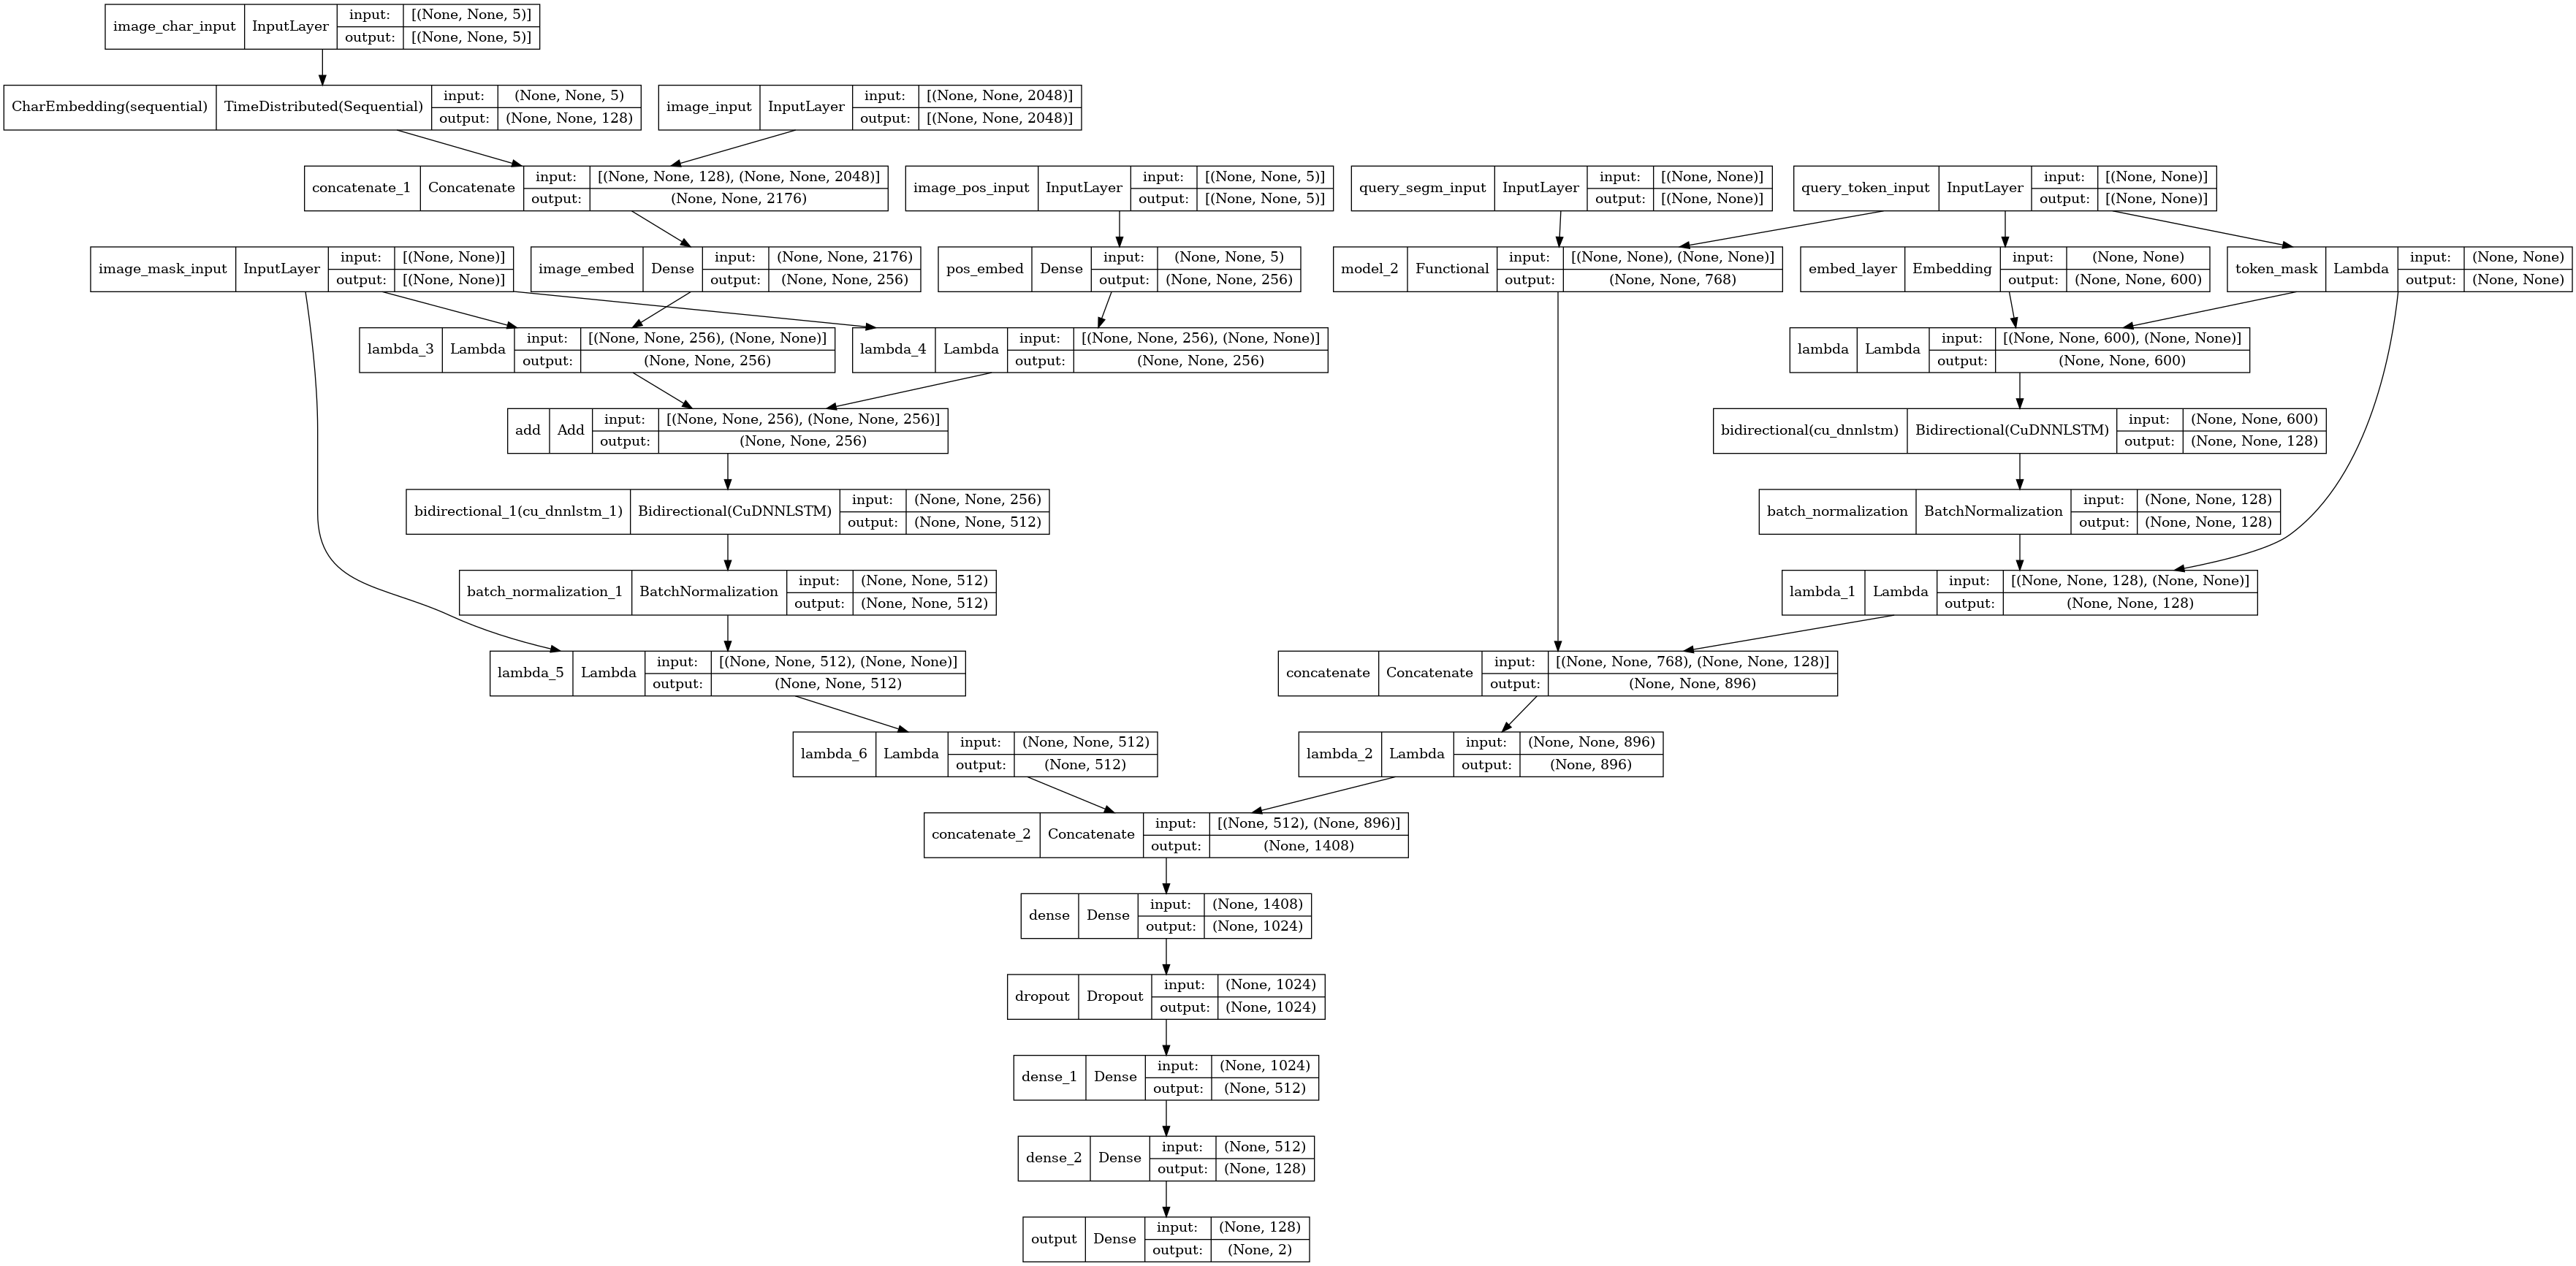

In [17]:

gc.collect()
fold_id = -1
# cfg["filename"] = cfg["raw_filename"].format(cfg["verbose"], FOLD_NUM, fold_id)

cfg["filename"] = 'models/100K_with_bert'

cfg["num_example"] = len(train_data)
print(len(train_data))

tf.compat.v1.keras.backend.clear_session()
gc.collect()
seed(SEED - fold_id)
np.random.seed(SEED - fold_id)
tf.compat.v1.random.set_random_seed(SEED - fold_id)
train_D = data_generator(train_data)
print(cfg)
model = build_model(cfg, summary=True, 
                    word_embedding_matrix=word_embedding_matrix,
                    )
tf.keras.utils.plot_model(model, to_file="models/model_with_bert.png", show_shapes=True)


In [18]:
evaluator = Evaluate(filename=cfg["filename"])
log_dir = "logs/fit/100k_with_bert"
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with open("data/val_data.pkl", "rb") as f:
    val_data = joblib.load(f)
    
model.fit(train_D.__iter__(),
                          steps_per_epoch=len(train_D),
                          epochs=MAX_EPOCH,
                          callbacks=[evaluator, tensorboard_callback],
                          shuffle=True
                          )

[!] test load&save model
Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.4438

100%|██████████| 14720/14720 [00:00<00:00, 81010.54it/s]


[!] epoch = 1, new NDCG best score = 0.3223798185880308
[!] epoch = 1, score = 0.3223798185880308, NDCG best score: 0.3223798185880308

391/391 [==============================] - 2363s 6s/step - loss: 0.4438 - accuracy: 0.4438 - nDCG@5: 0.3224
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.4471

100%|██████████| 14720/14720 [00:00<00:00, 78003.89it/s]


[!] epoch = 2, new NDCG best score = 0.3572781325069098
[!] epoch = 2, score = 0.3572781325069098, NDCG best score: 0.3572781325069098

391/391 [==============================] - 2309s 6s/step - loss: 0.3485 - accuracy: 0.4471 - nDCG@5: 0.3573
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.4485

100%|██████████| 14720/14720 [00:00<00:00, 83210.22it/s]


[!] epoch = 3, new NDCG best score = 0.36844434161636813
[!] epoch = 3, score = 0.36844434161636813, NDCG best score: 0.36844434161636813

391/391 [==============================] - 2309s 6s/step - loss: 0.3210 - accuracy: 0.4485 - nDCG@5: 0.3684
Epoch 4/20
391/391 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.4493

100%|██████████| 14720/14720 [00:00<00:00, 79912.91it/s]


[!] epoch = 4, score = 0.3633998080833625, NDCG best score: 0.36844434161636813

391/391 [==============================] - 2310s 6s/step - loss: 0.3112 - accuracy: 0.4493 - nDCG@5: 0.3634
Epoch 5/20
391/391 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.4491

100%|██████████| 14720/14720 [00:00<00:00, 68720.05it/s]


[!] epoch = 5, score = 0.36051010513755116, NDCG best score: 0.36844434161636813

391/391 [==============================] - 2313s 6s/step - loss: 0.2929 - accuracy: 0.4491 - nDCG@5: 0.3605
Epoch 6/20
391/391 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.4483

100%|██████████| 14720/14720 [00:00<00:00, 91146.33it/s]


[!] epoch = 6, score = 0.3675880879295717, NDCG best score: 0.36844434161636813

391/391 [==============================] - 2311s 6s/step - loss: 0.2917 - accuracy: 0.4483 - nDCG@5: 0.3676
Epoch 7/20
391/391 [==============================] - ETA: 0s - loss: 0.2771 - accuracy: 0.4502

100%|██████████| 14720/14720 [00:00<00:00, 115628.01it/s]

[!] epoch = 7, new NDCG best score = 0.3754635664340011
[!] epoch = 7, score = 0.3754635664340011, NDCG best score: 0.3754635664340011

391/391 [==============================] - 2316s 6s/step - loss: 0.2771 - accuracy: 0.4502 - nDCG@5: 0.3755
Epoch 8/20
391/391 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.4504

100%|██████████| 14720/14720 [00:00<00:00, 47709.84it/s]


[!] epoch = 8, new NDCG best score = 0.40268406517661093
[!] epoch = 8, score = 0.40268406517661093, NDCG best score: 0.40268406517661093

391/391 [==============================] - 2530s 6s/step - loss: 0.2828 - accuracy: 0.4504 - nDCG@5: 0.4027
Epoch 9/20
391/391 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.4519

100%|██████████| 14720/14720 [00:00<00:00, 81189.29it/s]


[!] epoch = 9, score = 0.3808558803760635, NDCG best score: 0.40268406517661093

391/391 [==============================] - 2327s 6s/step - loss: 0.2619 - accuracy: 0.4519 - nDCG@5: 0.3809
Epoch 10/20
391/391 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.4495

100%|██████████| 14720/14720 [00:00<00:00, 59535.44it/s]


[!] epoch = 10, new NDCG best score = 0.4190832250942992
[!] epoch = 10, score = 0.4190832250942992, NDCG best score: 0.4190832250942992

391/391 [==============================] - 3100s 8s/step - loss: 0.2725 - accuracy: 0.4495 - nDCG@5: 0.4191
Epoch 11/20
391/391 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.4458

100%|██████████| 14720/14720 [00:00<00:00, 81256.61it/s]


[!] epoch = 11, new NDCG best score = 0.426132479703279
[!] epoch = 11, score = 0.426132479703279, NDCG best score: 0.426132479703279

391/391 [==============================] - 2815s 7s/step - loss: 0.3092 - accuracy: 0.4458 - nDCG@5: 0.4261
Epoch 12/20
391/391 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.4471

100%|██████████| 14720/14720 [00:00<00:00, 78136.37it/s]


[!] epoch = 12, score = 0.39326007131436463, NDCG best score: 0.426132479703279

391/391 [==============================] - 3066s 8s/step - loss: 0.3113 - accuracy: 0.4471 - nDCG@5: 0.3933
Epoch 13/20
391/391 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.4480

100%|██████████| 14720/14720 [00:00<00:00, 71068.05it/s]


[!] epoch = 13, score = 0.41370942528239146, NDCG best score: 0.426132479703279

391/391 [==============================] - 2365s 6s/step - loss: 0.2899 - accuracy: 0.4480 - nDCG@5: 0.4137
Epoch 14/20
391/391 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.4482

100%|██████████| 14720/14720 [00:00<00:00, 50329.87it/s]


[!] epoch = 14, score = 0.4165302131918948, NDCG best score: 0.426132479703279

391/391 [==============================] - 2320s 6s/step - loss: 0.2824 - accuracy: 0.4482 - nDCG@5: 0.4165
Epoch 15/20
391/391 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.4484

100%|██████████| 14720/14720 [00:00<00:00, 54631.79it/s]


[!] epoch = 15, score = 0.39972698300451837, NDCG best score: 0.426132479703279

391/391 [==============================] - 2379s 6s/step - loss: 0.2707 - accuracy: 0.4484 - nDCG@5: 0.3997
Epoch 16/20
391/391 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.4488

100%|██████████| 14720/14720 [00:00<00:00, 60019.98it/s]


[!] epoch = 16, score = 0.4153133414233348, NDCG best score: 0.426132479703279

391/391 [==============================] - 2500s 6s/step - loss: 0.2696 - accuracy: 0.4488 - nDCG@5: 0.4153
Epoch 17/20
391/391 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.4479

100%|██████████| 14720/14720 [00:00<00:00, 77252.35it/s]


[!] epoch = 17, score = 0.41773686609489125, NDCG best score: 0.426132479703279

391/391 [==============================] - 3032s 8s/step - loss: 0.2596 - accuracy: 0.4479 - nDCG@5: 0.4177
Epoch 18/20
391/391 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.4487

100%|██████████| 14720/14720 [00:00<00:00, 97198.59it/s]


[!] epoch = 18, new NDCG best score = 0.4325923848331797
[!] epoch = 18, score = 0.4325923848331797, NDCG best score: 0.4325923848331797

391/391 [==============================] - 2360s 6s/step - loss: 0.2586 - accuracy: 0.4487 - nDCG@5: 0.4326
Epoch 19/20
391/391 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.4482

100%|██████████| 14720/14720 [00:00<00:00, 70699.48it/s]


[!] epoch = 19, new NDCG best score = 0.4528604068735726
[!] epoch = 19, score = 0.4528604068735726, NDCG best score: 0.4528604068735726

391/391 [==============================] - 2374s 6s/step - loss: 0.2496 - accuracy: 0.4482 - nDCG@5: 0.4529
Epoch 20/20
391/391 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.4490

100%|██████████| 14720/14720 [00:00<00:00, 73868.74it/s]

[!] epoch = 20, score = 0.3983959358423265, NDCG best score: 0.4528604068735726

391/391 [==============================] - 2351s 6s/step - loss: 0.2505 - accuracy: 0.4490 - nDCG@5: 0.3984


In [ ]:
%tensorboard 

## Hyperparameter Opt

In [ ]:
def build_model(hp):

    global cfg
    
    def _get_model(base_dir, cfg_=None):
        config_file = os.path.join(base_dir, 'bert_config.json')
        checkpoint_file = os.path.join(base_dir, 'bert_model.ckpt')
        if not os.path.exists(config_file):
            config_file = os.path.join(base_dir, 'bert_config_large.json')
            checkpoint_file = os.path.join(base_dir, 'roberta_l24_large_model')
        print(config_file, checkpoint_file)
#         model = load_trained_model_from_checkpoint(config_file, checkpoint_file, training=True, seq_len=cfg_['maxlen'])
        model = load_trained_model_from_checkpoint(config_file, 
                                           checkpoint_file, 
                                           training=False, 
                                           trainable=cfg_["bert_trainable"], 
                                           output_layer_num=cfg["cls_num"],
                                           seq_len=None)
        return model
    
    def get_opt(num_example, warmup_proportion=0.1, lr=2e-5, min_lr=None):
        if cfg["opt"].lower() == "nadam":
            opt = Nadam(lr=lr)
        else:
            total_steps, warmup_steps = calc_train_steps(
                num_example=num_example,
                batch_size=B_SIZE,
                epochs=MAX_EPOCH,
                warmup_proportion=warmup_proportion,
            )

            opt = AdamWarmup(total_steps, warmup_steps, lr=lr, min_lr=min_lr)

        return opt

    # model1 = _get_model(cfg["base_dir"], cfg)
    # model1 = Model(inputs=model1.inputs[: 2], outputs=model1.layers[-7].output)

    global word_index
    word_embedding_matrix = load_word_embed(word_index=word_index)
    embed_layer = Embedding(input_dim=word_embedding_matrix.shape[0], 
                            output_dim=word_embedding_matrix.shape[1],
                            weights=[word_embedding_matrix],
                            trainable=cfg["trainable"],
                            name="embed_layer"
                        )
        
    inp_token1 = Input(shape=(None, ), dtype=np.int32, name="query_token_input")
    inp_segm1 = Input(shape=(None, ), dtype=np.float32, name="query_segm_input")
    
#     inp_token2 = Input(shape=(None, ), dtype=np.int32)
#     inp_segm2 = Input(shape=(None, ), dtype=np.float32)    
    
    inp_image = Input(shape=(None, 2048), dtype=np.float32, name="image_input")
    inp_image_mask = Input(shape=(None, ), dtype=np.float32, name="image_mask_input")
    inp_pos = Input(shape=(None, 5), dtype=np.float32, name="image_pos_input")        
    inp_image_char = Input(shape=(None, cfg["max_char"]), dtype=np.int32, name='image_char_input')
    
    
    mask = Lambda(lambda x: K.cast(K.not_equal(x, cfg["x_pad"]), 'float32'), name="token_mask")(inp_token1)
    word_embed = embed_layer(inp_token1)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])
    
    # hp_units_lstm = hp.Int('lstm_units1', min_value=64, max_value=512, step=32)
    word_embed = Bidirectional(LSTM(cfg["unit1_1"], return_sequences=True), merge_mode="sum")(word_embed)
    word_embed = BatchNormalization()(word_embed)
    # word_embed = Dropout(0.3)(word_embed)
    word_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([word_embed, mask])

    # sequence_output = model1([inp_token1, inp_segm1])
    # sequence_output = Concatenate(axis=-1)([sequence_output, word_embed])
    text_pool = Lambda(lambda x: x[:, 0, :])(word_embed)

    # Share weights of character-level embedding for premise and hypothesis
    # hp_units_filter = hp.Int('filter_units1', min_value=64, max_value=512, step=32)
    # hp_units_filter_size = hp.Int('filter_size1', min_value=3, max_value=12, step=2)
    character_embedding_layer = TimeDistributed(Sequential([
        embed_layer,
        # Embedding(input_dim=100, output_dim=char_embedding_size, input_length=chars_per_word),
        Conv1D(filters=128, kernel_size=3, padding='same', name="char_embed_conv1d"),
        GlobalMaxPooling1D()
    ]), name='CharEmbedding')
    character_embedding_layer.build(input_shape=(None, None, cfg["max_char"]))
    image_char_embed  = character_embedding_layer(inp_image_char)    
    image_embed = Concatenate(axis=-1)([image_char_embed, inp_image])
    # hp_units0 = hp.Int('dense_units1', min_value=256, max_value=1024, step=32)
    hp_activation = hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu'])
    image_embed = Dense(256, activation=hp_activation, name='image_embed')(image_embed)

    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])


    # hp_units = hp.Int('dense_units2', min_value=256, max_value=2048, step=32)
    hp_activation = hp.Choice('activation2', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu'])
    hp_dropout_prop = hp.Choice('dropout_prop1', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    pos_embed = Dense(256, activation=hp_activation, name='pos_embed')(inp_pos)
    pos_embed = Dropout(hp_dropout_prop)(pos_embed)
    pos_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([pos_embed, inp_image_mask])
    embed = Add()([image_embed , pos_embed]) # batch, maxlen(10), 1024+128
    
    # hp_units_lstm0 = hp.Int('lstm_units1', min_value=64, max_value=512, step=32)
    image_embed = Bidirectional(LSTM(512, return_sequences=True), merge_mode="sum")(embed)
    image_embed = BatchNormalization()(image_embed)
    image_embed = Lambda(lambda x: x[0] * K.expand_dims(x[1], axis=-1))([image_embed, inp_image_mask])
    
    image_pool = Lambda(lambda x: x[:, 0, :])(image_embed)
    
    pool = Concatenate(axis=-1)([image_pool, text_pool])

    hp_units = hp.Int('dense_units3', min_value=64, max_value=2048, step=32)
    hp_activation = hp.Choice('activation3', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu'])
    hp_dropout_prop = hp.Choice('dropout_prop2', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    pool = Dense(hp_units, activation=hp_activation)(pool)
    pool = Dropout(hp_dropout_prop)(pool)
    hp_units1 = hp.Int('dense_units4', min_value=64, max_value=2048, step=32)
    hp_activation1 = hp.Choice('activation4', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu'])
    pool = Dense(hp_units1, activation=hp_activation1)(pool)
    hp_units2 = hp.Int('dense_units5', min_value=64, max_value=2048, step=32)
    hp_activation2 = hp.Choice('activation5', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu'])
    pool = Dense(hp_units2, activation=hp_activation2)(pool)
    
    output = Dense(2, activation='softmax', name='output')(pool)

    model = Model(inputs=[inp_token1, inp_segm1, 
                          inp_image, inp_image_mask,
                          inp_pos, inp_image_char], outputs=[output])#
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss={
                'output': 'sparse_categorical_crossentropy'
            }, metrics=['accuracy'])

    
    return model

#### Random Search

In [ ]:
np.random.seed(SEED)
tf.compat.v1.random.set_random_seed(SEED)

tuner = kt.RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=50,
                     directory='tmp/hyperparameter_tuning',
                     project_name='multimodal_hyperparameter_tuning',
                     overwrite=True,
                     seed=1)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
log_dir = "tmp/hparam_logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
tuner.search(train_D.__iter__(), epochs=20, validation_data=val_D.__iter__(), callbacks=[stop_early, tensorboard_callback],
            batch_size=1024, steps_per_epoch=len(train_D), validation_steps=len(val_D))


#### Hyperband

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=20,
                     factor=3,
                     directory='tmp/hyperband_hyperparameter_tuning',
                     project_name='multimodal_hyperband_hyperparameter_tuning',
                     overwrite=True,
                     seed=1)


In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
log_dir = "tmp/hparam_hyperband_logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

tuner.search(train_D.__iter__(), epochs=20, validation_data=val_D.__iter__(), callbacks=[stop_early, tensorboard_callback],
            batch_size=1024, steps_per_epoch=len(train_D), validation_steps=len(val_D))



In [ ]:
%tensorboard --logdir /tmp/hparam_logs

#### Select the best model

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=20,
                     factor=3,
                     directory='tmp/hyperband_hyperparameter_tuning',
                     project_name='multimodal_hyperband_hyperparameter_tuning',
                     overwrite=False,
                     seed=1)


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal parameters are {best_hps._hps}
""")

In [ ]:
hyperband_model = tuner.hypermodel.build(best_hps)

with open("data/val_data.pkl", "rb") as f:
    val_data = joblib.load(f)

evaluator = Evaluate(filename="hyperband_best_model")
log_dir = "logs/fit/Hyperband_best_hyparam" 
tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir)

hyperband_model.fit(train_D.__iter__(),
                          steps_per_epoch=len(train_D),
                          epochs=MAX_EPOCH,
                          callbacks=[evaluator, tensorboard_callback],
                          shuffle=True
                          )

### Distributed Hyperband

In [ ]:
# !export KERASTUNER_TUNER_ID="chief"
# !export KERASTUNER_ORACLE_IP="127.0.0.1"
# !export KERASTUNER_ORACLE_PORT="8000"
# !python hyperband_distributed.py